In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
class NormalBlock(nn.Module):
    multiplier: int = 1
    def __init__(self, in_channels, out_channels, is_down=False, shortcut_type='identity', use_bn=False, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.is_down = is_down
        self.shortcut_type = shortcut_type
        stride = 2 if is_down else 1
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1)
        self.batchnorm1 = nn.BatchNorm2d(out_channels) if use_bn else None

        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1)
        self.batchnorm2 = nn.BatchNorm2d(out_channels) if use_bn else None

        self.identity = nn.Identity() if shortcut_type=='identity' else None
        self.projection = nn.Conv2d(in_channels, out_channels, 1, stride, 0) if shortcut_type=='projection' else None

    def _padding(self, x, out):
        with torch.no_grad():
            pad_img_width, pad_img_height = out.shape[-1] - x.shape[-1], out.shape[-2] - x.shape[-2]
            pad_channels = out.shape[-3] - x.shape[-3]

            left = pad_img_width//2
            right = pad_img_width//2 + 1 if pad_img_width%2 != 0 else pad_img_width//2
            top = pad_img_height//2
            bottom = pad_img_height//2 + 1 if pad_img_height%2 != 0 else pad_img_height//2

            x = F.pad(x, (left, right, top, bottom, pad_channels//2, pad_channels//2), 'constant', 0)
        
        return x

    def forward(self, x):
        out = self.conv1(x)
        out = self.batchnorm1(out) if self.batchnorm1 != None else out
        out = F.relu(out)

        out = self.conv2(out)

        if self.shortcut_type == 'identity':
            x = self.identity(self._padding(x, out))
        if self.shortcut_type == 'projection':
            x = self.projection(x)
        
        out = out + x

        out = self.batchnorm2(out) if self.batchnorm2 != None else out
        out = F.relu(out)

        return out

In [4]:
class BottleneckBlock(nn.Module):
    multiplier: int = 4
    def __init__(self, in_channels, out_channels, is_down=False, shortcut_type='identity', use_bn=False, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.is_down = is_down
        self.shortcut_type = shortcut_type
        stride = 2 if is_down else 1
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, 1, 1, 0)
        self.batchnorm1 = nn.BatchNorm2d(out_channels) if use_bn else None

        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, stride, 1)
        self.batchnorm2 = nn.BatchNorm2d(out_channels) if use_bn else None

        self.conv3 = nn.Conv2d(out_channels, out_channels*self.multiplier, 1, 1, 0)
        self.batchnorm3 = nn.BatchNorm2d(out_channels*self.multiplier) if use_bn else None

        self.identity = nn.Identity() if shortcut_type=='identity' else None
        self.projection = nn.Conv2d(in_channels, out_channels*self.multiplier, 1, stride, 0) if shortcut_type=='projection' else None

    def _padding(self, x, out):
        pad_img_width, pad_img_height = out.shape[-1] - x.shape[-1], out.shape[-2] - x.shape[-2]
        pad_channels = out.shape[-3] - x.shape[-3]

        left = pad_img_width//2
        right = pad_img_width//2 + 1 if pad_img_width%2 != 0 else pad_img_width//2
        top = pad_img_height//2
        bottom = pad_img_height//2 + 1 if pad_img_height%2 != 0 else pad_img_height//2

        x = F.pad(x, (left, right, top, bottom, pad_channels//2, pad_channels//2), 'constant', 0)
        
        return x

    def forward(self, x):
        out = self.conv1(x)
        out = self.batchnorm1(out) if self.batchnorm1 != None else out
        out = F.relu(out)

        out = self.conv2(out)
        out = self.batchnorm2(out) if self.batchnorm2 != None else out
        out = F.relu(out)

        out = self.conv3(out)

        if self.shortcut_type == 'identity':
            x = self.identity(self._padding(x, out))
        if self.shortcut_type == 'projection':
            x = self.projection(x)
        
        out = out + x

        out = self.batchnorm3(out) if self.batchnorm2 != None else out
        out = F.relu(out)

        return out

In [5]:
class ResLayer(nn.Module):
    def __init__(self, block, num_blocks, in_channels, out_channels, is_down, shortcut_type, use_bn=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.first_layer = block(in_channels, out_channels, is_down, shortcut_type, use_bn)
        self.next_layers = nn.Sequential(*[
            block(out_channels*block.multiplier, out_channels, False, shortcut_type, use_bn) for _ in range(num_blocks-1)
            ])

    def forward(self, x):
        out = self.first_layer(x)
        out = self.next_layers(out)
        
        return out

In [6]:
class ResNet(nn.Module):
    def __init__(self, block, layers, shortcut_type, num_classes=1000, use_bn=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv1 = nn.Conv2d(3, 64, 7, 2, 3)

        self.maxpool1 = nn.MaxPool2d(3, 2, 1)

        self.layer2 = ResLayer(block, layers[0], 64, 64, is_down=False, shortcut_type=shortcut_type, use_bn=use_bn)

        self.layer3 = ResLayer(block, layers[1], 64*block.multiplier, 128, is_down=True, shortcut_type=shortcut_type, use_bn=use_bn)
        self.layer4 = ResLayer(block, layers[2], 128*block.multiplier, 256, is_down=True, shortcut_type=shortcut_type, use_bn=use_bn)
        self.layer5 = ResLayer(block, layers[3], 256*block.multiplier, 512, is_down=True, shortcut_type=shortcut_type, use_bn=use_bn)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*block.multiplier, num_classes)


    def forward(self, x):
        out = self.conv1(x)
        out = self.maxpool1(out)

        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        
        out = self.avgpool(out)
        out = out.view(x.shape[0], -1)
        out = self.fc(out)

        return  out

In [7]:
def ResNet18(shortcut_type='identity', use_bn=True):
    return ResNet(block=NormalBlock, layers=[2, 2, 2, 2], shortcut_type=shortcut_type, use_bn=use_bn)

def ResNet34(shortcut_type='identity', use_bn=True):
    return ResNet(block=NormalBlock, layers=[3, 4, 6, 3], shortcut_type=shortcut_type, use_bn=use_bn)

def ResNet50(shortcut_type='projection', use_bn=True):
    return ResNet(block=BottleneckBlock, layers=[3, 4, 6, 3], shortcut_type=shortcut_type, use_bn=use_bn)

def ResNet101(shortcut_type='identity', use_bn=True):
    return ResNet(block=BottleneckBlock, layers=[3, 4, 23, 3], shortcut_type=shortcut_type, use_bn=use_bn)

def ResNet152(shortcut_type='identity', use_bn=True):
    return ResNet(block=BottleneckBlock, layers=[3, 8, 36, 3], shortcut_type=shortcut_type, use_bn=use_bn)

In [11]:
model = ResNet50('identity').to(device)
x = torch.zeros(1, 3, 224, 224).to(device)
output = model(x)
sum([p.numel() for p in model.parameters()])/1e6, output.shape

(22.803048, torch.Size([1, 1000]))

In [13]:
torch.onnx.export(model, x, 'resnet34.onnx', input_names=['Image'], output_names=['Class'])

/tmp/ipykernel_137118/655519081.py:25: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  right = pad_img_width//2 + 1 if pad_img_width%2 != 0 else pad_img_width//2
/tmp/ipykernel_137118/655519081.py:27: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  bottom = pad_img_height//2 + 1 if pad_img_height%2 != 0 else pad_img_height//2
/home/darthcoder/miniconda3/envs/PyTorchGPU/lib/python3.10/site-packages/torch/onnx/utils.py:702: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Trigg

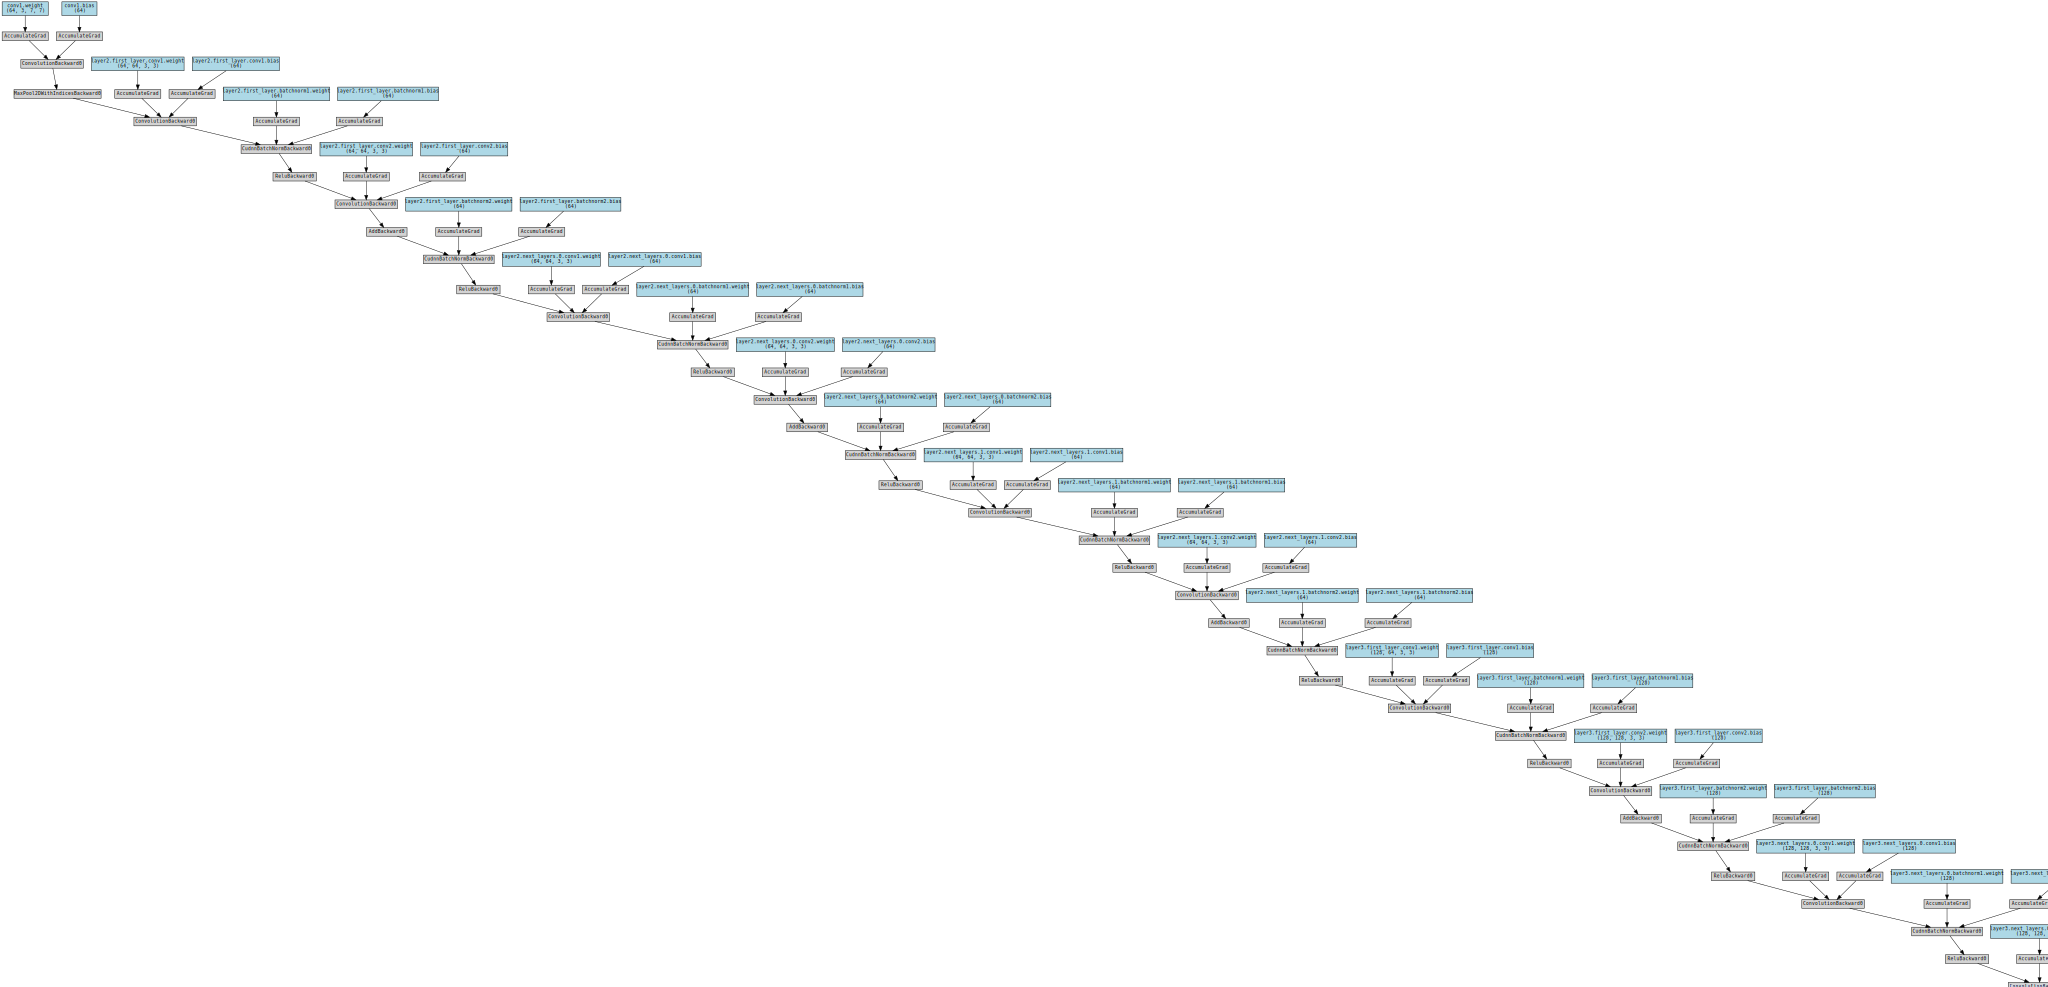

In [14]:
from torchviz import make_dot

make_dot(output, dict(model.named_parameters()))